In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
enigh_data = pd.read_csv("enigh_processed_tidy.csv")

In [ ]:
# Define the mapping of state codes to state names
state_codes = {
    1: 'AGUASCALIENTES', 2: 'BAJA CALIFORNIA', 3: 'BAJA CALIFORNIA SUR', 4: 'CAMPECHE',
    5: 'COAHUILA DE ZARAGOZA', 6: 'COLIMA', 7: 'CHIAPAS', 8: 'CHIHUAHUA', 9: 'DISTRITO FEDERAL',
    10: 'DURANGO', 11: 'GUANAJUATO', 12: 'GUERRERO', 13: 'HIDALGO', 14: 'JALISCO', 15: 'MEXICO',
    16: 'MICHOACAN DE OCAMPO', 17: 'MORELOS', 18: 'NAYARIT', 19: 'NUEVO LEON', 20: 'OAXACA',
    21: 'PUEBLA', 22: 'QUERETARO DE ARTEAGA', 23: 'QUINTANA ROO', 24: 'SAN LUIS POTOSI', 25: 'SINALOA',
    26: 'SONORA', 27: 'TABASCO', 28: 'TAMAULIPAS', 29: 'TLAXCALA', 30: 'VERACRUZ DE IGNACIO DE LA LLAVE',
    31: 'YUCATAN', 32: 'ZACATECAS', 33: 'ENTIDAD FEDERATIVA NO ESPECIFICADA'
}

# Map 'entidad' in the data to state names
enigh_data['state_name'] = enigh_data['entidad'].map(state_codes)


In [ ]:
# Group by state, municipality, and year to calculate mean income and Gini coefficient
summary_stats = enigh_data.groupby(['entidad', 'municipio', 'year']).agg(
    avg_income=('ing_cor', 'mean'),
    gini_mean=('gini_year', 'mean')
).reset_index()

# Map state codes to names for readability
summary_stats['state_name'] = summary_stats['entidad'].map(state_codes)

# Display the summary table
summary_stats.head()

,entidad,municipio,year,avg_income,gini_mean,state_name
0,1,1,2018,61924.935159,0.394781,AGUASCALIENTES
1,1,1,2020,58953.487980,0.384018,AGUASCALIENTES
2,1,1,2022,80197.105304,0.413504,AGUASCALIENTES
3,1,2,2018,67197.038429,0.602021,AGUASCALIENTES
4,1,2,2020,42520.348241,0.342393,AGUASCALIENTES


In [ ]:
# Create a pivot table to show average income by state and year
income_pivot = summary_stats.pivot_table(
    index=['state_name', 'municipio'],
    columns='year',
    values='avg_income'
)

# Display the pivot table
income_pivot

year                              2018          2020          2022
state_name     municipio                                          
AGUASCALIENTES 1          61924.935159  58953.487980  80197.105304
               2          67197.038429  42520.348241  56032.530982
               3          37616.768145  48725.141250  60625.802882
               4                   NaN  50108.640000  42181.936667
               5          60695.117027  59505.024613  75407.982720
...                                ...           ...           ...
ZACATECAS      53         35943.440682  34982.034426  40356.085909
               54         26862.057576  30131.153662  27399.041636
               55                  NaN  37514.535000  45198.052778
               56         54960.174590  54197.002130  69421.874818
               57                  NaN  36941.180400  62783.353333

[1528 rows x 3 columns]

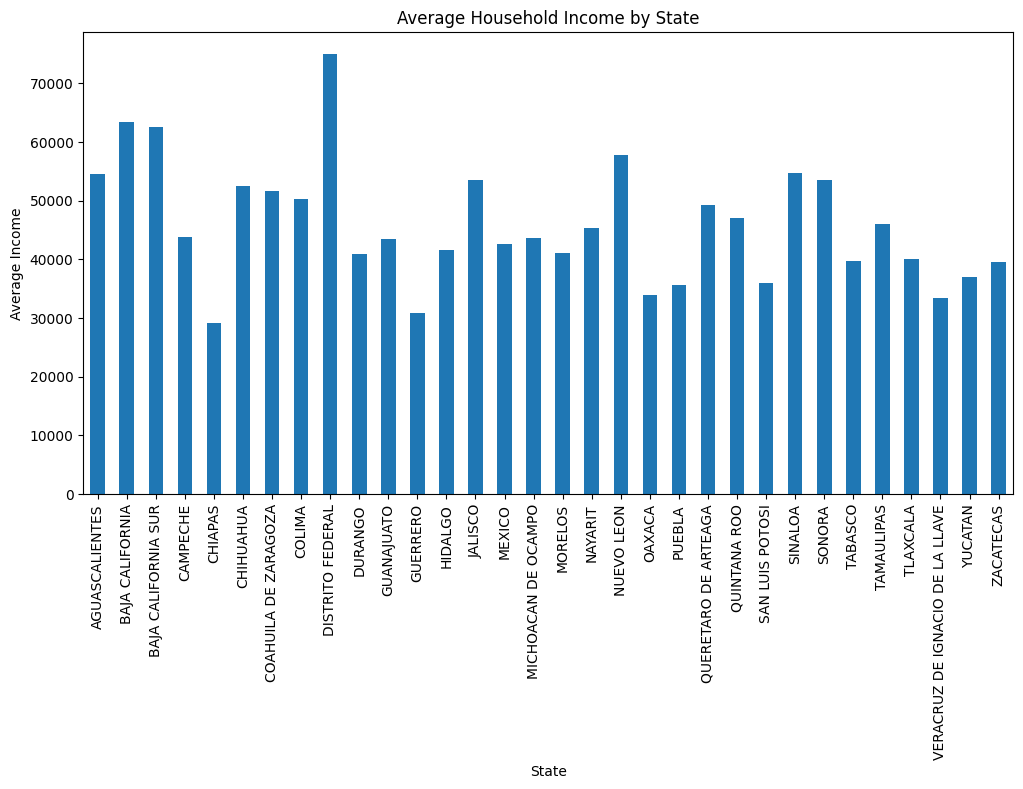

In [ ]:
# Plot average income by state
plt.figure(figsize=(12, 6))
summary_stats.groupby('state_name')['avg_income'].mean().plot(kind='bar')
plt.title('Average Household Income by State')
plt.xlabel('State')
plt.ylabel('Average Income')
plt.xticks(rotation=90)
plt.show()


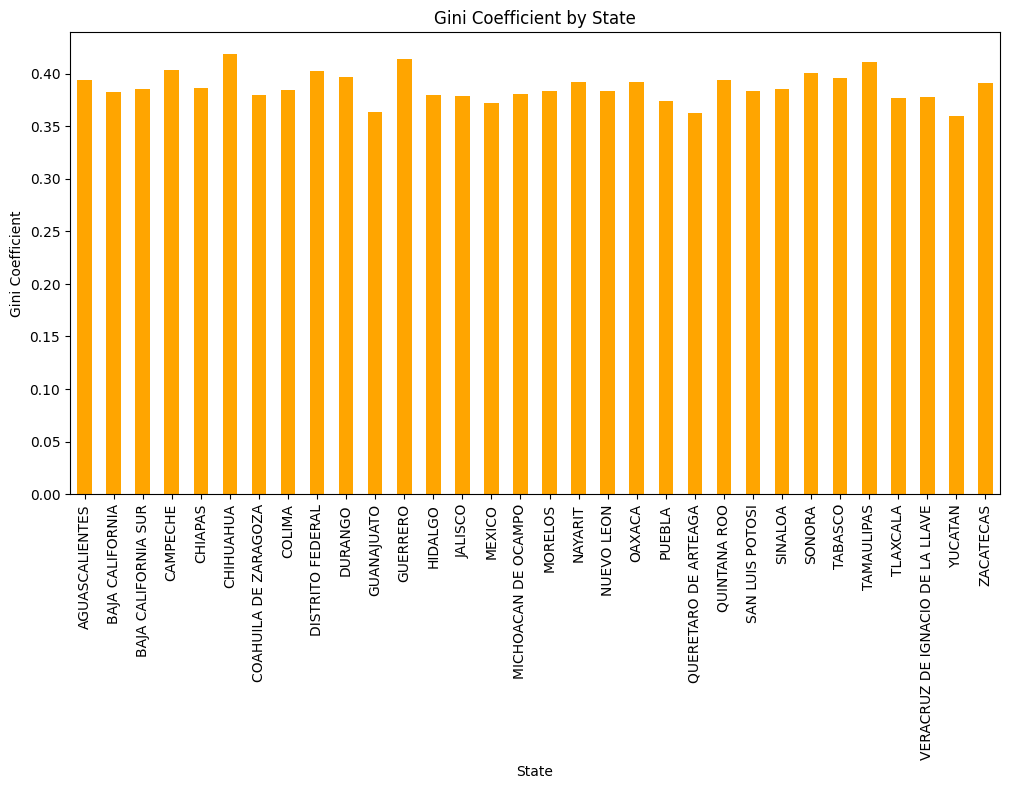

In [ ]:
# Plot Gini coefficient by state
plt.figure(figsize=(12, 6))
summary_stats.groupby('state_name')['gini_mean'].mean().plot(kind='bar', color='orange')
plt.title('Gini Coefficient by State')
plt.xlabel('State')
plt.ylabel('Gini Coefficient')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Prepare data by resetting and melting the pivot table
income_pivot_reset = income_pivot.reset_index()
income_long = income_pivot_reset.melt(id_vars="state_name", var_name="year", value_name="avg_income")

# Aggregate data by state and year to get the mean income for each state
state_totals = income_long.groupby(['state_name', 'year'], as_index=False).agg(
    total_income=('avg_income', 'mean')  # Or use 'mean' for average if preferred
)

In [ ]:
# Create an interactive line plot with state totals
fig = px.line(
    state_totals,
    x="year",
    y="total_income",
    color="state_name",
    title="Total Household Income by Year for Each State",
    labels={"total_income": "Total Income", "year": "Year", "state_name": "State"},
    markers=True
)

# Customize the hover template to show the correct values
fig.update_traces(
    hovertemplate="<b>State: %{customdata[0]}</b><br>Year: %{x}<br>Avg Income: %{y:,.2f}",
    customdata=state_totals[['state_name']]
)

# Enable legend toggling for better visualization
fig.update_layout(
    legend_title="States",
    hovermode="x unified"
)

# Show the plot
fig.show()

In [ ]:
# Filter to only include data for years 2018, 2020, and 2022
filtered_income_long = income_long[income_long['year'].isin([2018, 2020, 2022])]

# Aggregate data by state and year for the total income
state_totals_heatmap = filtered_income_long.groupby(['state_name', 'year'], as_index=False).agg(
    total_income=('avg_income', 'mean')  # Use 'mean' if you prefer the average
)

# Pivot the data to create a heatmap-friendly format
state_totals_pivot = state_totals_heatmap.pivot(index='state_name', columns='year', values='total_income')

In [ ]:
# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=state_totals_pivot.values,
    x=state_totals_pivot.columns,  # Years 2018, 2020, 2022
    y=state_totals_pivot.index,     # States
    colorscale="YlGnBu",
    colorbar=dict(title="Total Income")
))

# Update layout for clarity
fig.update_layout(
    title="Total Household Income by State for 2018, 2020, and 2022",
    xaxis_title="Year",
    yaxis_title="State",
    yaxis=dict(tickmode="array", tickvals=list(state_totals_pivot.index), ticktext=list(state_totals_pivot.index))
)

# Show the interactive heatmap
fig.show()

In [ ]:
# Group by state and year to get the average Gini coefficient for each state
state_gini = enigh_data.groupby(['state_name', 'year'], as_index=False).agg(
    avg_gini=('gini_year', 'mean')
)
# Pivot data to format suitable for a heatmap
state_gini_pivot = state_gini.pivot(index='state_name', columns='year', values='avg_gini')

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=state_gini_pivot.values,
    x=state_gini_pivot.columns,  # Years
    y=state_gini_pivot.index,     # States
    colorscale="YlOrRd",
    colorbar=dict(title="Gini Coefficient")
))

# Update layout for readability
fig.update_layout(
    title="Gini Coefficient by State Across Years",
    xaxis_title="Year",
    yaxis_title="State",
    yaxis=dict(tickmode="array", tickvals=list(state_gini_pivot.index), ticktext=list(state_gini_pivot.index))
)

# Show the interactive heatmap
fig.show()

In [ ]:
# Group data by state and year for both average income and Gini coefficient
state_summary = enigh_data.groupby(['state_name', 'year'], as_index=False).agg(
    avg_income=('ing_cor', 'mean'),  # Average income per state and year
    avg_gini=('gini_year', 'mean')   # Average Gini coefficient per state and year
)
for state_name in state_summary['state_name'].unique():
    state_data = state_summary[state_summary['state_name'] == state_name]

    # Create figure
    fig = go.Figure()

    # Add trace for average income
    fig.add_trace(
        go.Scatter(
            x=state_data['year'],
            y=state_data['avg_income'],
            name="Average Income",
            mode="lines+markers",
            line=dict(color="blue"),
            yaxis="y1"
        )
    )

    # Add trace for Gini coefficient
    fig.add_trace(
        go.Scatter(
            x=state_data['year'],
            y=state_data['avg_gini'],
            name="Gini Coefficient",
            mode="lines+markers",
            line=dict(color="red"),
            yaxis="y2"
        )
    )

    # Update layout for dual-axis
    fig.update_layout(
        title=f"Average Income and Gini Coefficient Trends for {state_name}",
        xaxis=dict(title="Year"),
        yaxis=dict(
            title="Average Income",
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue"),
        ),
        yaxis2=dict(
            title="Gini Coefficient",
            titlefont=dict(color="red"),
            tickfont=dict(color="red"),
            overlaying="y",
            side="right"
        ),
        legend=dict(x=0.1, y=0.9),
        hovermode="x unified"
    )

    # Show the plot for each state
    fig.show()

In [ ]:
# Sort data by state and year
state_summary_sorted = state_summary.sort_values(by=['state_name', 'year'])

# Calculate percent changes in average income and Gini coefficient
state_summary_sorted['income_change'] = state_summary_sorted.groupby('state_name')['avg_income'].pct_change() * 100
state_summary_sorted['gini_change'] = state_summary_sorted.groupby('state_name')['avg_gini'].pct_change() * 100

# Define a function to classify the relationship between income and Gini changes
def classify_change(row):
    if row['income_change'] > 0 and row['gini_change'] > 0:
        return 'Both Increase'
    elif row['income_change'] < 0 and row['gini_change'] < 0:
        return 'Both Decrease'
    elif row['income_change'] > 0 and row['gini_change'] < 0:
        return 'Income Up, Gini Down'
    elif row['income_change'] < 0 and row['gini_change'] > 0:
        return 'Income Down, Gini Up'
    else:
        return 'No Significant Change'

# Apply the function to classify each row
state_summary_sorted['change_classification'] = state_summary_sorted.apply(classify_change, axis=1)

# Filter out rows where either income_change or gini_change is NaN
state_summary_filtered = state_summary_sorted.dropna(subset=['income_change', 'gini_change'])

# Re-run the change classification and grouping
yearly_change_summary_filtered = state_summary_filtered.groupby(['year', 'change_classification']).size().reset_index(name='count')

# Display the updated summary
print(yearly_change_summary_filtered)


   year change_classification  count
0  2020         Both Decrease      5
1  2020         Both Increase      9
2  2020  Income Down, Gini Up      5
3  2020  Income Up, Gini Down     13
4  2022         Both Increase      7
5  2022  Income Up, Gini Down     25


In [ ]:
# Count occurrences of each classification by state
state_change_summary = state_summary_sorted.groupby(['state_name', 'year', 'change_classification']).size().reset_index(name='count')

# Display summary
state_change_summary

,state_name,year,change_classification,count
0,AGUASCALIENTES,2018,No Significant Change,1
1,AGUASCALIENTES,2020,Both Decrease,1
2,AGUASCALIENTES,2022,Both Increase,1
3,BAJA CALIFORNIA,2018,No Significant Change,1
4,BAJA CALIFORNIA,2020,Both Increase,1
...,...,...,...,...
91,YUCATAN,2020,"Income Down, Gini Up",1
92,YUCATAN,2022,"Income Up, Gini Down",1
93,ZACATECAS,2018,No Significant Change,1
94,ZACATECAS,2020,Both Increase,1


In [ ]:
# Sort the data by state and year
state_summary_sorted = state_summary.sort_values(by=['state_name', 'year'])

# Calculate year-over-year percentage changes for average income and Gini coefficient
state_summary_sorted['income_pct_change'] = state_summary_sorted.groupby('state_name')['avg_income'].pct_change() * 100
state_summary_sorted['gini_pct_change'] = state_summary_sorted.groupby('state_name')['avg_gini'].pct_change() * 100


In [ ]:
# Select the relevant columns to create the final table
percentage_change_table = state_summary_sorted[['state_name', 'year', 'income_pct_change', 'gini_pct_change']]

# Display the table
percentage_change_table

,state_name,year,income_pct_change,gini_pct_change
0,AGUASCALIENTES,2018,NaN,NaN
1,AGUASCALIENTES,2020,-3.513248,-3.497226
2,AGUASCALIENTES,2022,31.590666,6.148895
3,BAJA CALIFORNIA,2018,NaN,NaN
4,BAJA CALIFORNIA,2020,21.041217,4.147573
...,...,...,...,...
91,YUCATAN,2020,-5.180182,1.880556
92,YUCATAN,2022,39.569401,-5.603378
93,ZACATECAS,2018,NaN,NaN
94,ZACATECAS,2020,14.657287,1.818858


In [ ]:
# Define mappings for tam_loc and est_socio
tam_loc_mapping = {1: 'Urban (100,000+)', 2: 'Urban (15,000-99,999)', 3: 'Rural (2,500-14,999)', 4: 'Rural (<2,500)'}
est_socio_mapping = {1: 'Low', 2: 'Medium Low', 3: 'Medium High', 4: 'High'}

# Map tam_loc and est_socio to their respective descriptions
enigh_data['tam_loc_label'] = enigh_data['tam_loc'].map(tam_loc_mapping)
enigh_data['est_socio_label'] = enigh_data['est_socio'].map(est_socio_mapping)

In [ ]:
# Aggregate data to calculate average income and Gini coefficient
municipality_est = enigh_data.groupby(['state_name', 'municipio', 'year', 'est_socio_label', 'gini_year']).agg(
    avg_income=('ing_cor', 'mean')        # Average Gini coefficient
).reset_index()

municipality_est



,state_name,municipio,year,est_socio_label,gini_year,avg_income
0,AGUASCALIENTES,1,2018,High,0.394781,96071.179817
1,AGUASCALIENTES,1,2018,Medium High,0.394781,59047.409746
2,AGUASCALIENTES,1,2018,Medium Low,0.394781,52328.011580
3,AGUASCALIENTES,1,2020,High,0.384018,89281.743974
4,AGUASCALIENTES,1,2020,Medium High,0.384018,59050.050860
...,...,...,...,...,...,...
4990,ZACATECAS,56,2022,High,0.417031,110093.851224
4991,ZACATECAS,56,2022,Medium High,0.417031,69885.142083
4992,ZACATECAS,56,2022,Medium Low,0.417031,43158.811795
4993,ZACATECAS,57,2020,Medium Low,0.414361,36941.180400


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
data_pca = pd.read_csv("enigh_processed_tidy.csv")

In [ ]:
# Selecting main variables related to income, demographic, and socioeconomic status for correlation analysis
main_variables = [
    'ing_cor', 'ingtrab', 'trabajo', 'negocio', 'rentas', 'utilidad', 'arrenda',
    'transfer', 'jubilacion', 'becas', 'donativos', 'remesas', 'bene_gob',
    'estim_alqu', 'otros_ing', 'edad_jefe', 'tot_integ', 'hombres', 'mujeres',
    'mayores', 'menores', 'gini_year', 'decile'
]

# Calculate the correlation matrix for these main variables
correlation_matrix = data_pca[main_variables].corr()

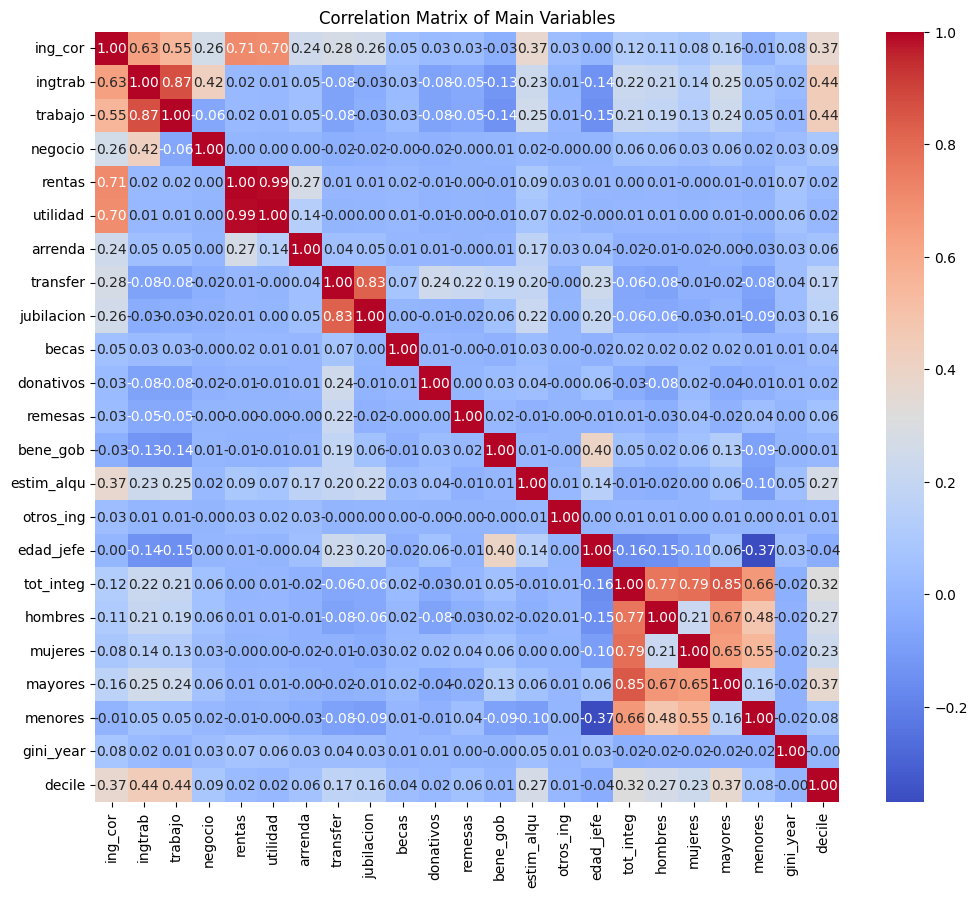

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Main Variables")
plt.show()